# Exercise 4

### Necessary imports

In [ ]:
import os
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.spatial import distance
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import random
import warnings
from sklearn.preprocessing import Normalizer

### Dataset loading

In [7]:
directory = 'dataset/20_NGs_400'
list_of_vectors = []

for filenames in os.listdir(directory):
    for file in os.listdir(directory + "/" + filenames):
        f = open(directory + "/" + filenames + "/" + file, "r")
        list_of_vectors.append(f.read())

### Creating the FVM with CountVectorizer and target list

In [36]:
vectorizer = CountVectorizer(stop_words='english')
vectors_dataset = vectorizer.fit_transform(list_of_vectors)

target = []
for i in range(20):
    for j in range(20):
        target.append(i)

In [37]:
def count_doc_positives(target:list, target_class:int) -> int:
    return target.count(target_class)

### Defining the rocchio method for obtaining the vector of features for each classes

In [38]:
def rocchio_method(train:list, target:list, num_class:int, beta:int, gamma:int) -> list:
    c = []
    for i in range(num_class):
        pos = []
        neg = []
        pos_word_num = []
        neg_word_num = []
        for index, x in enumerate(train):
            if(target[index] == i):
                pos.append(x)
            else:
                neg.append(x)
    
        positive_examples = count_doc_positives(target, i)
        negative_examples = len(target) - positive_examples
        
        pos_word_num = np.array([sum(x) for x in zip(*pos)]) / positive_examples
        neg_word_num = np.array([sum(x) for x in zip(*neg)]) / negative_examples

        c.append((beta * (pos_word_num)) - (gamma * neg_word_num))
    return c

### Defining the function for predicting the class of a document, comparing the cosine similarity of the document with the vectors of profiles given by Rocchio Method

In [115]:
def predict_rocchio(profiles:list, test:list, target:list, misure:str) -> list:
    prediction = []
    best_vector = None
    for x in test:
        distance_misure = 100000
        for index, proto in enumerate(profiles):
            match misure:
                case "euclidean":
                    transformer = Normalizer()
                    similarity = distance.euclidean(transformer.fit(x), proto)
                    if(similarity < distance_misure):
                        distance_misure = similarity
                        best_vector = index
                case "cosine":
                    similarity = distance.cosine(x, proto)
                    if(similarity < distance_misure):
                        distance_misure = similarity
                        best_vector = index
                case "angular distance":
                    similarity = 1 - ( np.arccos(distance.cosine(x, proto)) / np.pi )
                    if(similarity < distance_misure):
                        distance_misure = similarity
                        best_vector = index
        prediction.append(target[best_vector])
    return prediction

### Splitting the dataset into training and test set and getting the profiles with Rocchio Method and the predictions for the test set

In [64]:
X_train, X_test, y_train, y_test = train_test_split(vectors_dataset.toarray(), target, test_size=0.10, random_state=42)
profiles = rocchio_method(X_train, y_train, 20, 16, 4)
predict_value = predict_rocchio(profiles, X_test, y_test)

In [95]:
print("Accuracy Score: ", accuracy_score(y_test, predict_value))
print("F1 Score: ", f1_score(y_test, predict_value, average='macro'))
print("Precision Score: ", precision_score(y_test, predict_value, average='macro'))
print("Recall Score: ", recall_score(y_test, predict_value, average='macro'))

Accuracy Score:  0.1
F1 Score:  0.0634920634920635
Precision Score:  0.058823529411764705
Recall Score:  0.10784313725490195


c:\Users\lores\Desktop\esercizi-radicioni\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Plotting the confusion matrix for the test set

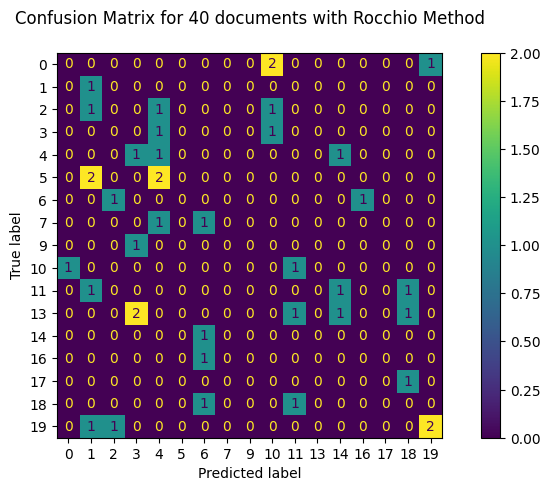

In [93]:
fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_test, predict_value, ax=ax)
_ = ax.set_title(
    f"Confusion Matrix for {len(y_test)} documents with Rocchio Method\n"
)

### Implementing the cross validation for the dataset with 10 folds and getting the mean accuracy

In [116]:
accuracy_scores = []
f1_scores = []
precision_scores = []
recall_scores = []
for i in random.sample(range(0, 10000), 10):
    X_train, X_test, y_train, y_test = train_test_split(vectors_dataset.toarray(), target, test_size=0.10, random_state=i)
    profiles = rocchio_method(X_train, y_train, 20, 16, 4)
    predict_value = predict_rocchio(profiles, X_test, y_test, misure="cosine")
    accuracy_scores.append(accuracy_score(y_test, predict_value))
    f1_scores.append(f1_score(y_test, predict_value, average='macro'))
    precision_scores.append(precision_score(y_test, predict_value, average='macro'))
    recall_scores.append(recall_score(y_test, predict_value, average='macro'))
print("Mean Accuracy Score: ", np.mean(accuracy_scores))
print("Mean F1 Score: ", np.mean(f1_scores))
print("Mean Precision Score: ", np.mean(precision_scores))
print("Mean Recall Score: ", np.mean(recall_scores))

Mean Accuracy Score:  0.11000000000000001
Mean F1 Score:  0.07018661292268104
Mean Precision Score:  0.06402055703107046
Mean Recall Score:  0.0913301226923518
